# Explanatory Data Analysis for Patogenicity Problem - Data including information from the CSQ column.

The aim of this EDA was to inspect a properties and potential usefulness of the CSQ data. It is not a full EDA for the whole data. It is based on the previous versions of EDA but I tried to duplicate as little information as possible. Generally the notebook shows the properties of the CSQ data alone and compared to the rest of the data.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import allel
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
import dalex as dx
from sklearn.model_selection import LeaveOneOut
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

In [ ]:
EE_015 = allel.vcf_to_dataframe("data/EE_015/EE_015.vcf.gz", ["#CHROM", "POS", "ID", "REF", "ALT", "QUAL", "FILTER", "INFO"])
EE_050 = allel.vcf_to_dataframe("data/EE_050/EE_050.vcf.gz", ["#CHROM", "POS", "ID", "REF", "ALT", "QUAL", "FILTER", "INFO"])
EE_069 = allel.vcf_to_dataframe("data/EE_069/EE_069.vcf.gz", ["#CHROM", "POS", "ID", "REF", "ALT", "QUAL", "FILTER", "INFO"])

C:\Users\Krzysiaczek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\allel\io\vcf_read.py:1240: UserWarning: '#CHROM' INFO header not found
  warnings.warn('%r INFO header not found' % name)
C:\Users\Krzysiaczek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\allel\io\vcf_read.py:1454: UserWarning: no type for field 'variants/#CHROM', assuming object
  warnings.warn('no type for field %r, assuming %s' % (f, normed_types[f]))
C:\Users\Krzysiaczek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\allel\io\vcf_read.py:1564: UserWarning: no number for field 'variants/#CHROM', assuming 1
  warnings.warn('no number for field %r, assuming 1' % f)
C:\Users\Krzysiaczek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Pytho

In [ ]:
EE_015.drop(columns="CSQ", inplace=True)
EE_050.drop(columns="CSQ", inplace=True)
EE_069.drop(columns="CSQ", inplace=True)

In [ ]:
EE_015_CSQ = pd.read_csv("data/EE_015/EE_015_csq.csv.gz", sep=";", compression="gzip")
EE_050_CSQ = pd.read_csv("data/EE_050/EE_050_csq.csv.gz", sep=";", compression="gzip")
EE_069_CSQ = pd.read_csv("data/EE_069/EE_069_csq.csv.gz", sep=";", compression="gzip")


C:\Users\Krzysiaczek\AppData\Local\Temp\ipykernel_7524\2111465853.py:1: DtypeWarning: Columns (26,40,74,75,76,78,80) have mixed types. Specify dtype option on import or set low_memory=False.
  EE_015_CSQ = pd.read_csv("data/EE_015/EE_015_csq.csv.gz", sep=";", compression="gzip")
C:\Users\Krzysiaczek\AppData\Local\Temp\ipykernel_7524\2111465853.py:2: DtypeWarning: Columns (26,40,74,75,76,78,80,94) have mixed types. Specify dtype option on import or set low_memory=False.
  EE_050_CSQ = pd.read_csv("data/EE_050/EE_050_csq.csv.gz", sep=";", compression="gzip")
C:\Users\Krzysiaczek\AppData\Local\Temp\ipykernel_7524\2111465853.py:3: DtypeWarning: Columns (26,40,74,75,76,78,80,96) have mixed types. Specify dtype option on import or set low_memory=False.
  EE_069_CSQ = pd.read_csv("data/EE_069/EE_069_csq.csv.gz", sep=";", compression="gzip")


Construct two data frames
* df - all data (regular columns and split CSQ)
* df_csq - only data from the CSQ

In [ ]:
df = pd.concat([EE_015, EE_050, EE_069], ignore_index=True)
df_csq = pd.concat([EE_015_CSQ, EE_050_CSQ, EE_069_CSQ], ignore_index=True)

In [ ]:
df_csq.columns = [col + "_csq" for col in df_csq.columns]

In [ ]:
df  = pd.merge(df, df_csq, left_index=True, right_index=True)
df

,#CHROM,POS,ID,REF,ALT_1,ALT_2,ALT_3,QUAL,FILTER_PASS,FILTER_SB,...,SpliceAI_pred_DP_DG_csq,SpliceAI_pred_DP_DL_csq,SpliceAI_pred_DS_AG_csq,SpliceAI_pred_DS_AL_csq,SpliceAI_pred_DS_DG_csq,SpliceAI_pred_DS_DL_csq,SpliceAI_pred_SYMBOL_csq,LOEUF_csq,PHENOTYPES_csq,NMD_csq
0,NaN,15820,rs2691315,G,T,NaN,NaN,NaN,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,17385,rs201535981,G,A,NaN,NaN,NaN,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,17697,rs71260069,G,C,NaN,NaN,NaN,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,133129,rs367730352,G,A,NaN,NaN,NaN,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,183629,rs71267774,G,A,NaN,NaN,NaN,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444439,NaN,56856571,rs9988391,G,A,NaN,NaN,293.769989,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
444440,NaN,56856581,rs9320083,G,A,NaN,NaN,750.770020,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
444441,NaN,56856587,rs7067511,A,C,NaN,NaN,1164.770020,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
444442,NaN,56856668,rs5013140,A,G,NaN,NaN,467.769989,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Add the target column to CSQ data.

In [ ]:
df_csq['ACMG_class'] = df['ACMG_class']

Drop forbiden attributes.

In [ ]:
columns_to_drop = [col for col in df.columns if 'ACMG' in col and col != 'ACMG_class' or 'AMP' in col]
df = df.drop(columns=columns_to_drop)

Below Visualization is meant to provide information about the number of NaNs in chosen columns. Basically, we choose every column that has more than 100 000 Nans, meaning around 1/4th. We see that more columns are fully or mostly filled with NaNs than for the regular data, therfore many will have to be dropped.

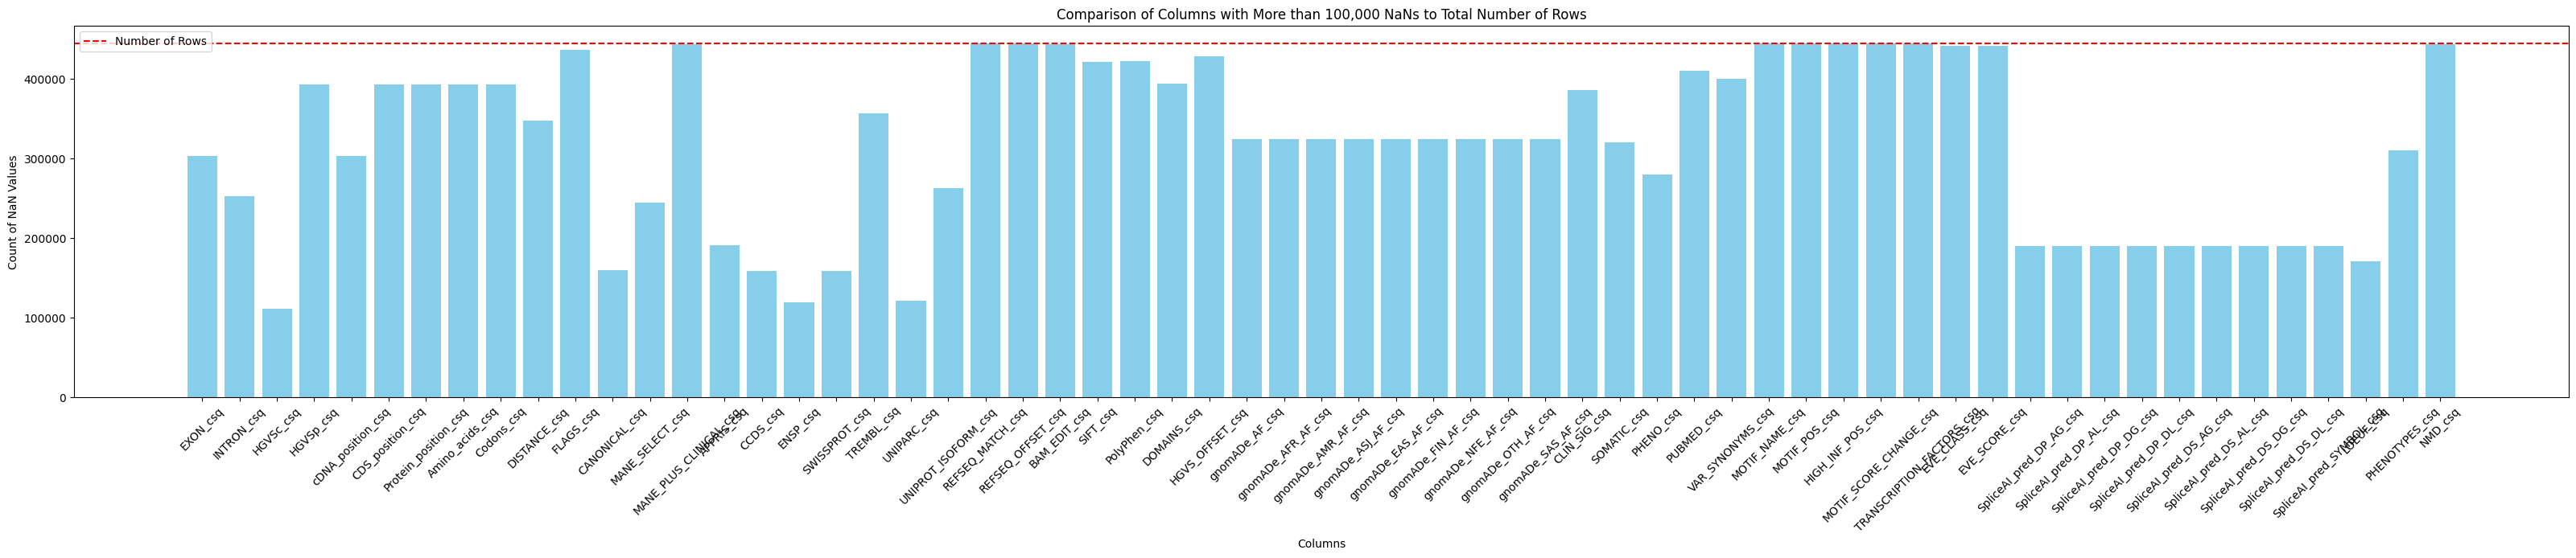

In [ ]:
columns_with_nans = []
nan_counts = []
nan_threshold = 100000

for column in df_csq.columns:
    nan_count = df_csq[column].isna().sum()
    if nan_count > nan_threshold:
        columns_with_nans.append(column)
        nan_counts.append(nan_count)

total_rows = len(df_csq)

plt.figure(figsize=(40, 6))
plt.bar(columns_with_nans, nan_counts, color='skyblue')
plt.axhline(y=total_rows, color='r', linestyle='--', label='Number of Rows')
plt.xlabel('Columns')
plt.ylabel('Count of NaN Values')
plt.title('Comparison of Columns with More than 100,000 NaNs to Total Number of Rows')
plt.legend()
plt.xticks(rotation=45)
plt.show()

Dropping all columns with more than 400000 Nans

In [ ]:
nan_threshold = 400000

df = df.dropna(axis=1, thresh=len(df) - nan_threshold)
df_csq = df_csq.dropna(axis=1, thresh=len(df) - nan_threshold)

Looking through unique values for "object"(usually string) columns

In [ ]:
for column in df_csq.select_dtypes(include=['object']):
    unique_values_count = df_csq[column].nunique()
    print(f"Column '{column}' has {unique_values_count} unique values.")

Column 'Allele_csq' has 2350 unique values.
Column 'Consequence_csq' has 94 unique values.
Column 'IMPACT_csq' has 4 unique values.
Column 'SYMBOL_csq' has 23274 unique values.
Column 'Gene_csq' has 26563 unique values.
Column 'Feature_type_csq' has 3 unique values.
Column 'Feature_csq' has 29670 unique values.
Column 'BIOTYPE_csq' has 40 unique values.
Column 'EXON_csq' has 2106 unique values.
Column 'INTRON_csq' has 3345 unique values.
Column 'HGVSc_csq' has 207583 unique values.
Column 'HGVSp_csq' has 29179 unique values.
Column 'cDNA_position_csq' has 14065 unique values.
Column 'CDS_position_csq' has 6518 unique values.
Column 'Protein_position_csq' has 3400 unique values.
Column 'Amino_acids_csq' has 793 unique values.
Column 'Codons_csq' has 1429 unique values.
Column 'Existing_variation_csq' has 268960 unique values.
Column 'SYMBOL_SOURCE_csq' has 3 unique values.
Column 'HGNC_ID_csq' has 22705 unique values.
Column 'CANONICAL_csq' has 1 unique values.
Column 'MANE_SELECT_csq' 

Visualizing numbers of unique values for every "object" attribute, that way we may know if we should treat them as categorical or not.

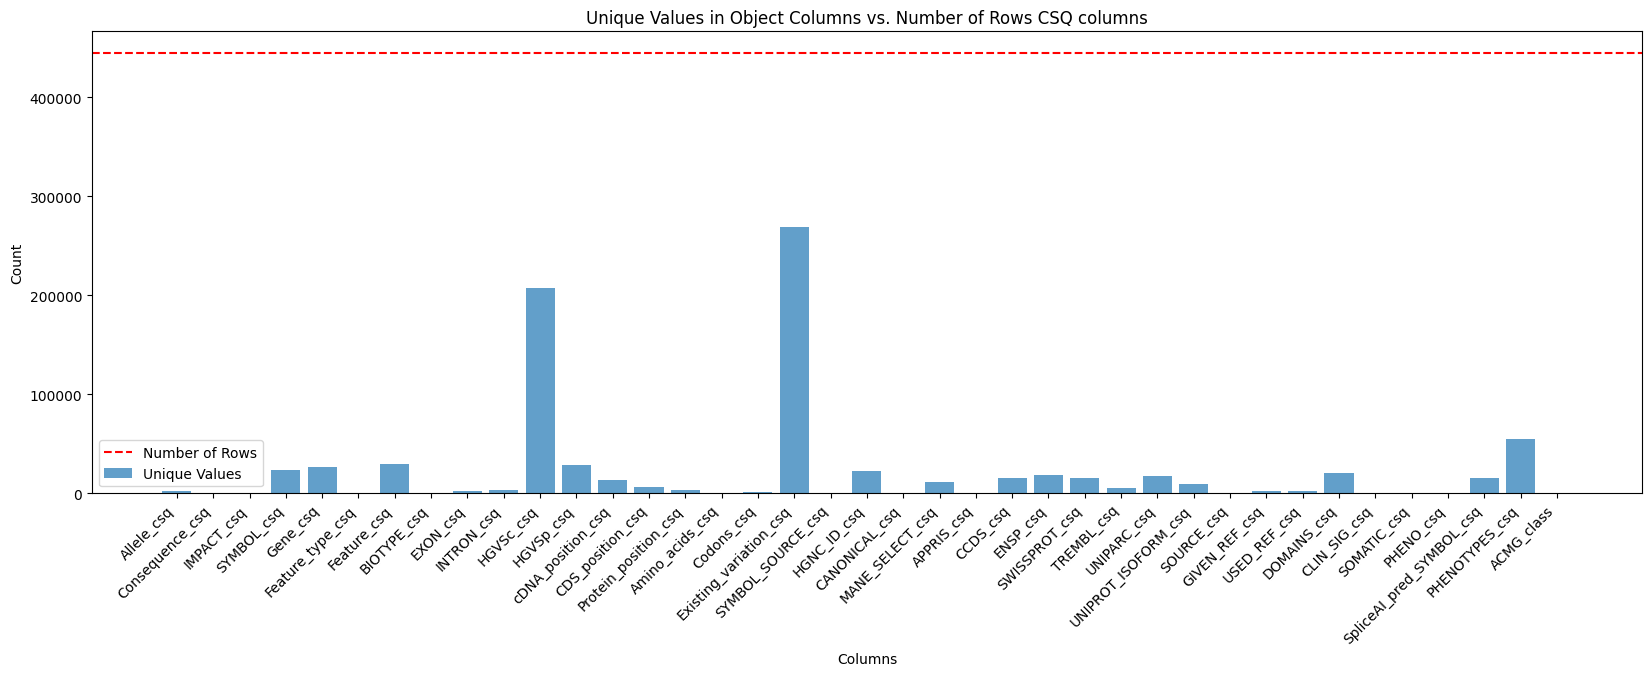

In [ ]:
unique_value_counts = []
column_names = []
for column in df_csq.select_dtypes(include=['object']):
    column_names.append(column)
    unique_values_count = df_csq[column].nunique()
    unique_value_counts.append(unique_values_count)

num_rows = len(df_csq)

plt.figure(figsize=(20, 6))
plt.bar(column_names, unique_value_counts, label='Unique Values', alpha=0.7)
plt.axhline(y=num_rows, color='r', linestyle='--', label='Number of Rows')
plt.xlabel('Columns')
plt.ylabel('Count')
plt.title('Unique Values in Object Columns vs. Number of Rows CSQ columns')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.show()


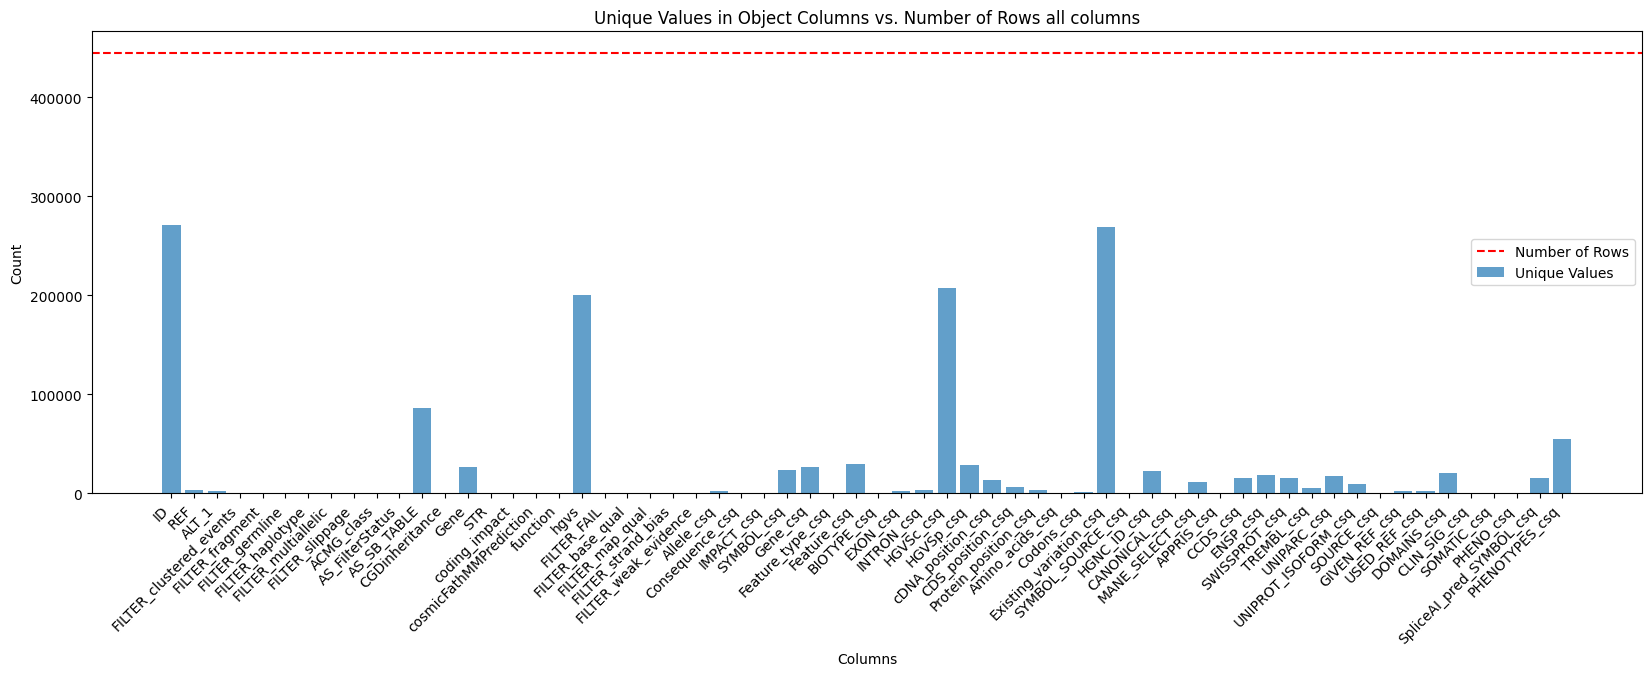

In [ ]:
unique_value_counts = []
column_names = []
for column in df.select_dtypes(include=['object']):
    column_names.append(column)
    unique_values_count = df[column].nunique()
    unique_value_counts.append(unique_values_count)

num_rows = len(df)

plt.figure(figsize=(20, 6))
plt.bar(column_names, unique_value_counts, label='Unique Values', alpha=0.7)
plt.axhline(y=num_rows, color='r', linestyle='--', label='Number of Rows')
plt.xlabel('Columns')
plt.ylabel('Count')
plt.title('Unique Values in Object Columns vs. Number of Rows all columns')
plt.legend()
plt.xticks(rotation=45, ha="right")
plt.show()


Changing every attribute that has less than 10000 unique values to a category.

In [ ]:
unique_value_threshold = 10000


for column in df.select_dtypes(include=['object']):
    unique_values_count = df[column].nunique()
    if unique_values_count < unique_value_threshold:
        df[column] = df[column].astype('category')

for column in df_csq.select_dtypes(include=['object']):
    unique_values_count = df_csq[column].nunique()
    if unique_values_count < unique_value_threshold:
        df_csq[column] = df_csq[column].astype('category')


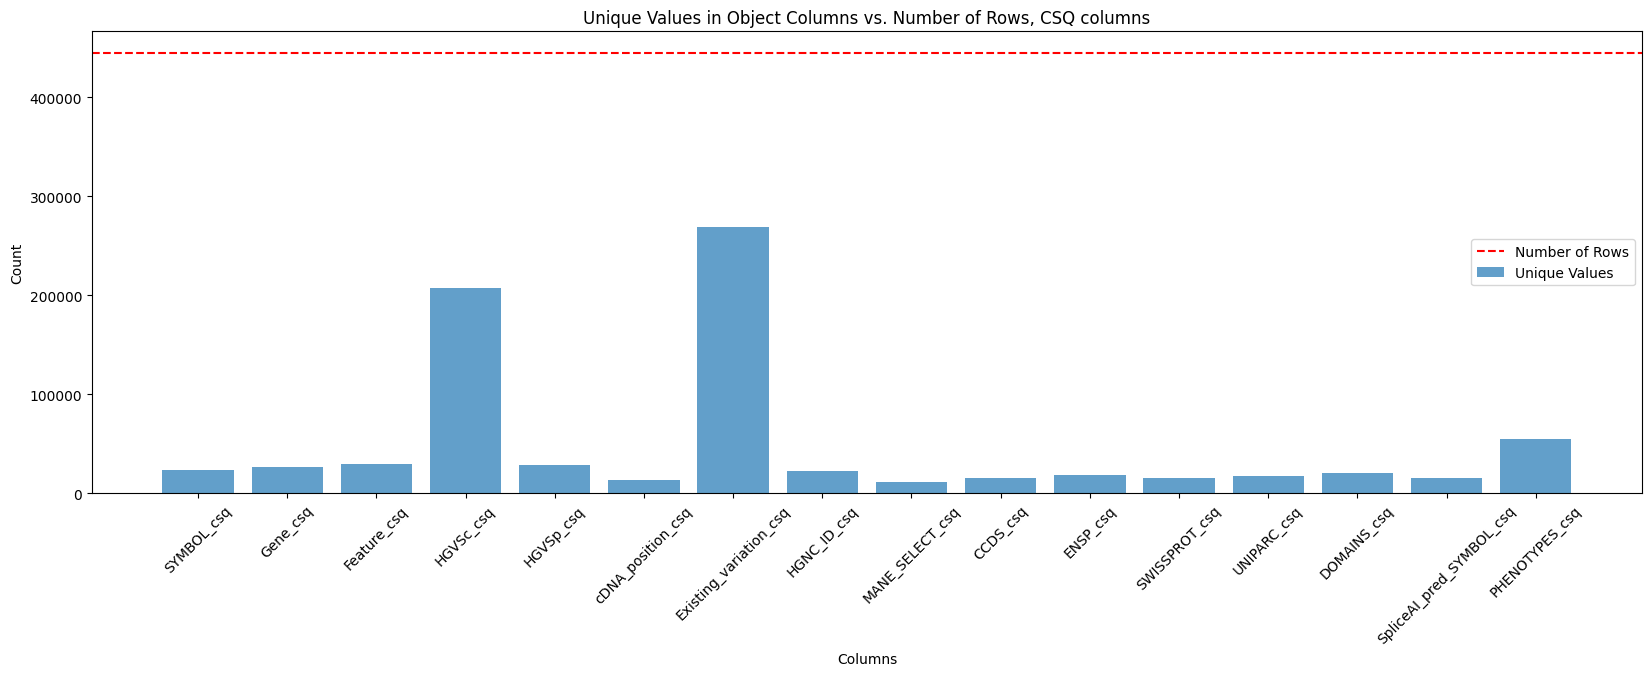

In [ ]:
unique_value_counts = []
column_names = []
for column in df_csq.select_dtypes(include=['object']):
    column_names.append(column)
    unique_values_count = df_csq[column].nunique()
    unique_value_counts.append(unique_values_count)

num_rows = len(df_csq)

plt.figure(figsize=(20, 6))
plt.bar(column_names, unique_value_counts, label='Unique Values', alpha=0.7)
plt.axhline(y=num_rows, color='r', linestyle='--', label='Number of Rows')
plt.xlabel('Columns')
plt.ylabel('Count')
plt.title('Unique Values in Object Columns vs. Number of Rows, CSQ columns')
plt.legend()
plt.xticks(rotation=45)
plt.show()

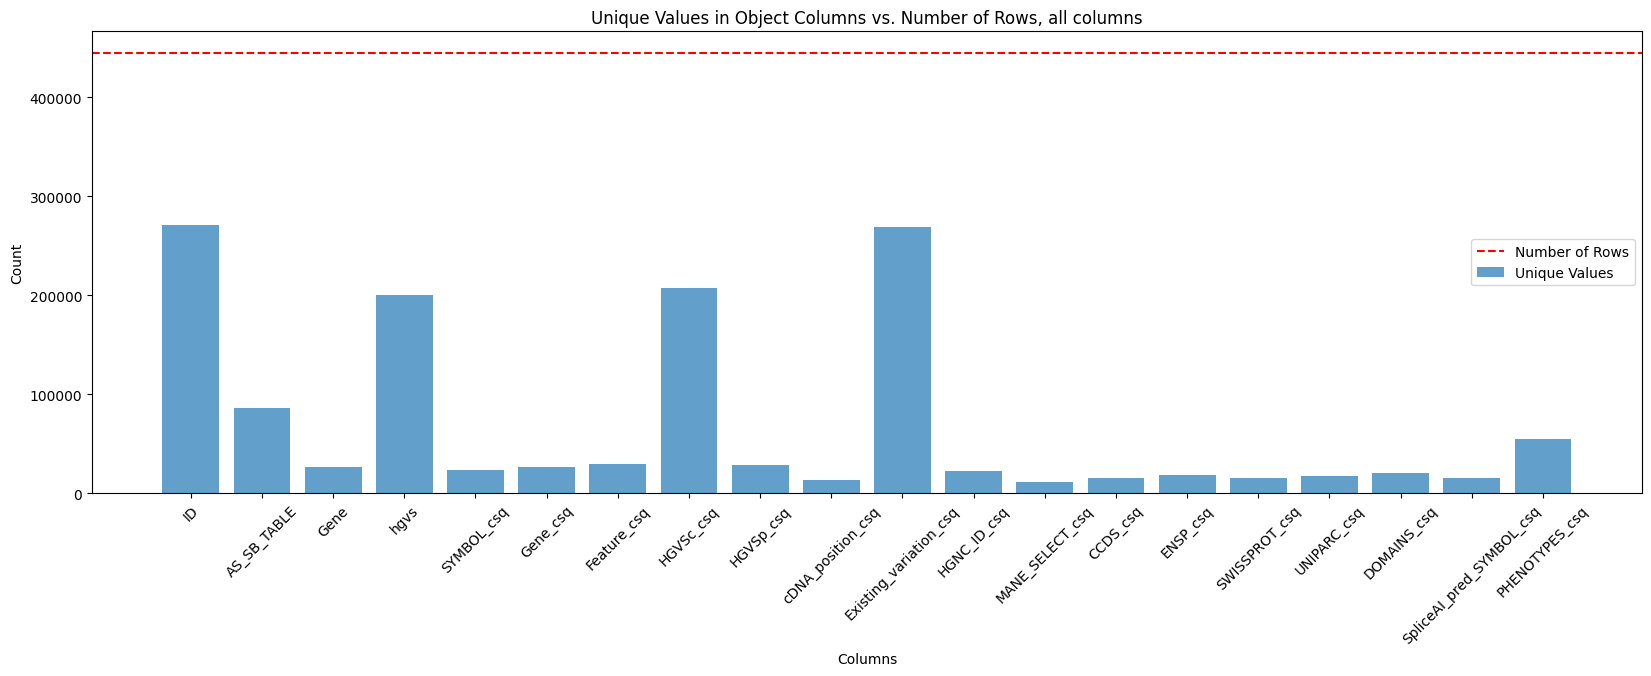

In [ ]:
unique_value_counts = []
column_names = []
for column in df.select_dtypes(include=['object']):
    column_names.append(column)
    unique_values_count = df[column].nunique()
    unique_value_counts.append(unique_values_count)

num_rows = len(df)

plt.figure(figsize=(20, 6))
plt.bar(column_names, unique_value_counts, label='Unique Values', alpha=0.7)
plt.axhline(y=num_rows, color='r', linestyle='--', label='Number of Rows')
plt.xlabel('Columns')
plt.ylabel('Count')
plt.title('Unique Values in Object Columns vs. Number of Rows, all columns')
plt.legend()
plt.xticks(rotation=45)
plt.show()

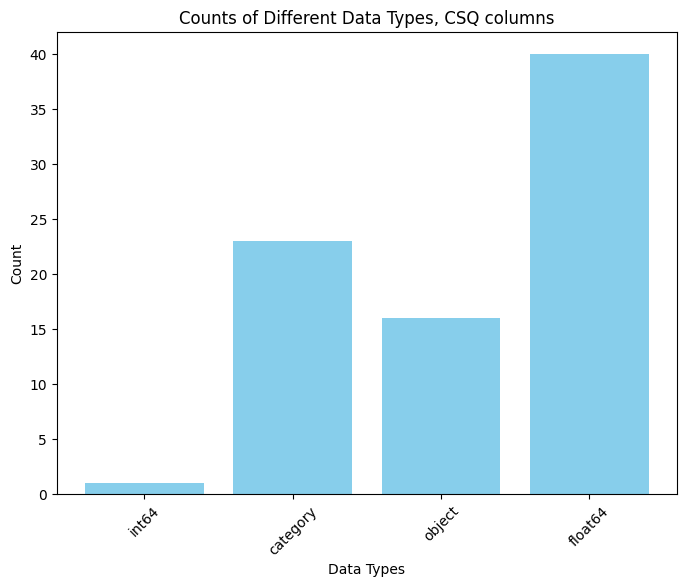

In [ ]:
dtype_counts={}
for val in df_csq.dtypes:
    try:
        dtype_counts[str(val)]+=1
    except:
        dtype_counts[str(val)]=1

data_types = list(dtype_counts.keys())
counts = list(dtype_counts.values())

plt.figure(figsize=(8, 6))
plt.bar(data_types, counts, color='skyblue')
plt.xlabel('Data Types')
plt.ylabel('Count')
plt.title('Counts of Different Data Types, CSQ columns')
plt.xticks(rotation=45)
plt.show()

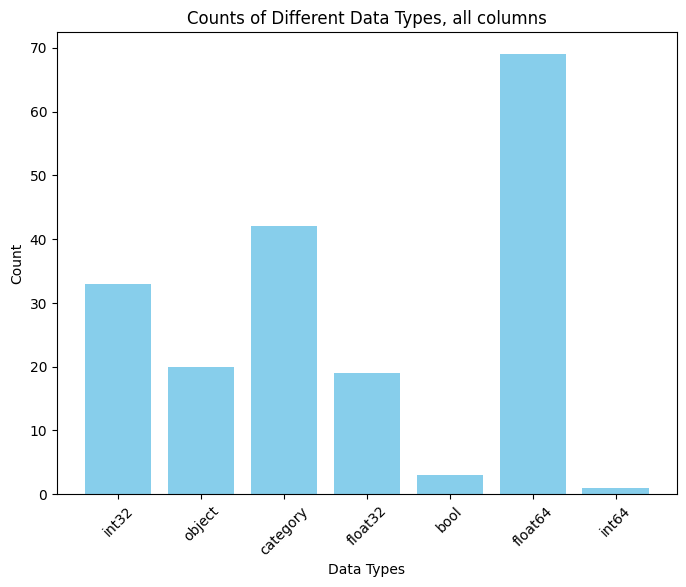

In [ ]:
dtype_counts={}
for val in df.dtypes:
    try:
        dtype_counts[str(val)]+=1
    except:
        dtype_counts[str(val)]=1

data_types = list(dtype_counts.keys())
counts = list(dtype_counts.values())

plt.figure(figsize=(8, 6))
plt.bar(data_types, counts, color='skyblue')
plt.xlabel('Data Types')
plt.ylabel('Count')
plt.title('Counts of Different Data Types, all columns')
plt.xticks(rotation=45)
plt.show()

Heatmap showing correlation of 15 attributes with highest average correlation.

With heatmaps we can see that some of the attributes in CSQ are basically copies of regular columns. They have almost 100% corelation and very simmilar names.

On the other hand for the CSQ data alone correlations are significantly lower than for the rest of the data. There are no so many groups with the corelation at the level of 100%.

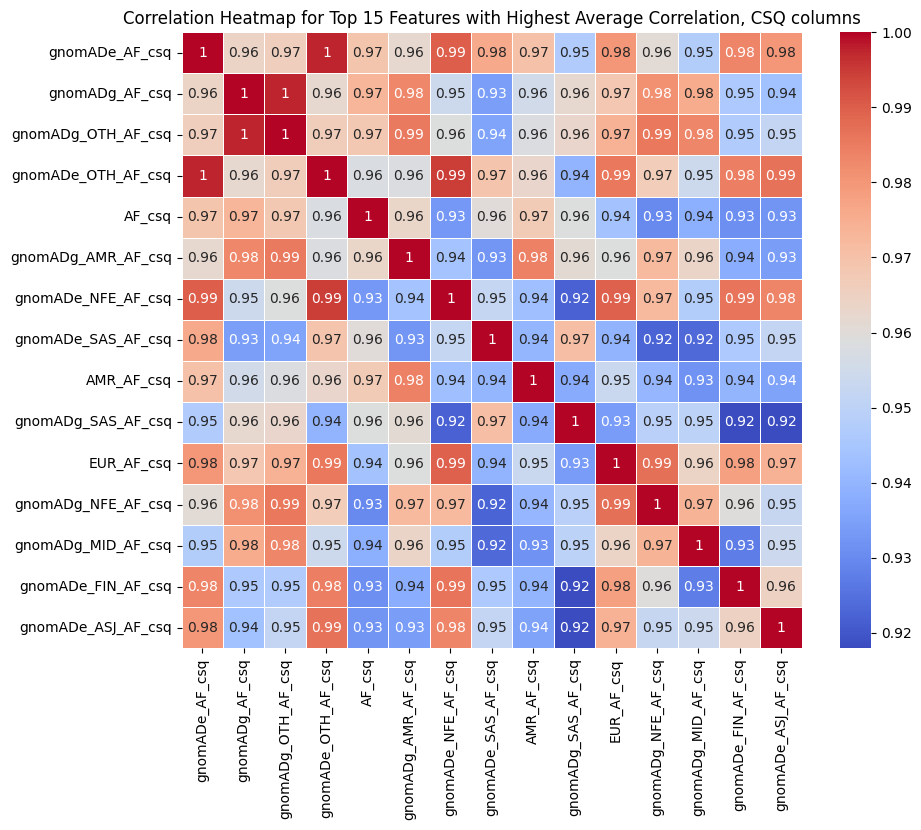

In [ ]:
numeric_df = df_csq.select_dtypes(include=['int64', 'float64', 'bool', 'float32', 'int64'])


correlation_matrix = numeric_df.corr()
average_correlation = correlation_matrix.abs().mean(axis=1)
top_features = average_correlation.nlargest(15).index

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix.loc[top_features, top_features], annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Heatmap for Top 15 Features with Highest Average Correlation, CSQ columns')
plt.show()

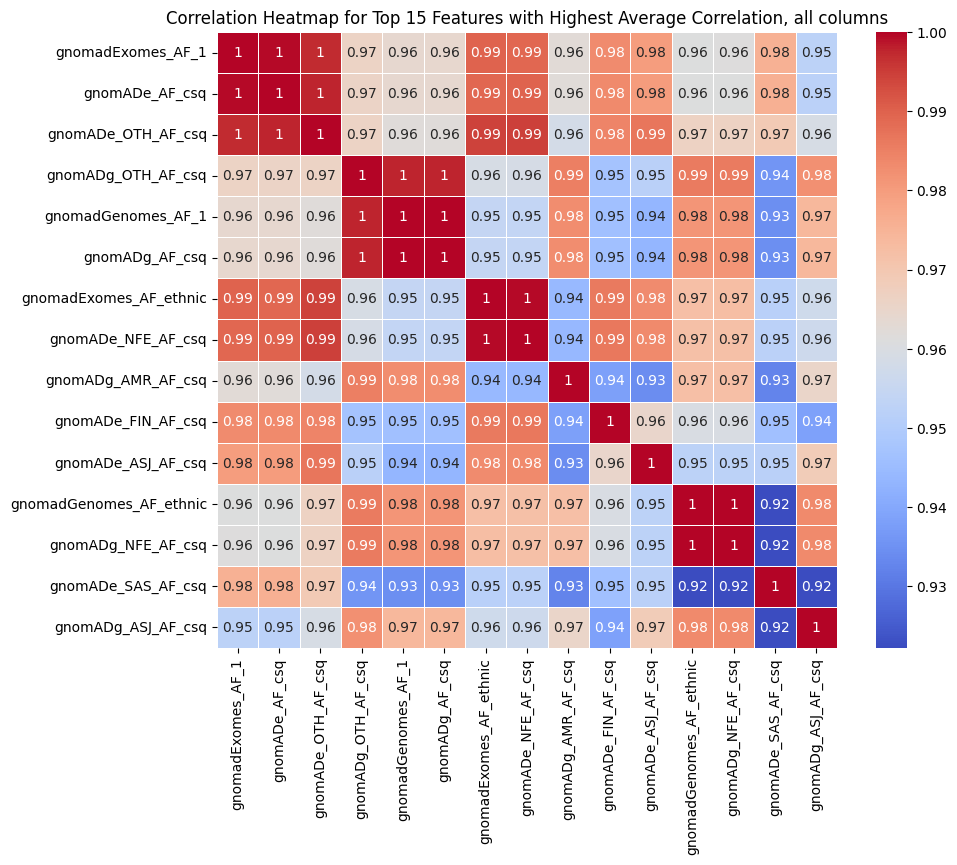

In [ ]:
numeric_df = df.select_dtypes(include=['int64', 'float64', 'bool', 'float32', 'int64'])


correlation_matrix = numeric_df.corr()
average_correlation = correlation_matrix.abs().mean(axis=1)
top_features = average_correlation.nlargest(15).index

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix.loc[top_features, top_features], annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Heatmap for Top 15 Features with Highest Average Correlation, all columns')
plt.show()

Below, everything that was an object was changed to category, same for some numerical attributes that had less than 25 000 unique values. This should probably be reviewed and possibly changed in the final implementation.

This is the only parameter i have changed compared to the original EDA as it produced only two attributes for the CSQ.

In [ ]:
unique_value_threshold = 25000

df_csq_copy = df_csq.copy()
df_copy = df.copy()

for column in df.columns:
    unique_values_count = df[column].nunique()
    if unique_values_count < unique_value_threshold:
        df[column] = df[column].astype('category')

for column in df_csq.columns:
    unique_values_count = df_csq[column].nunique()
    if unique_values_count < unique_value_threshold:
        df_csq[column] = df_csq[column].astype('category')



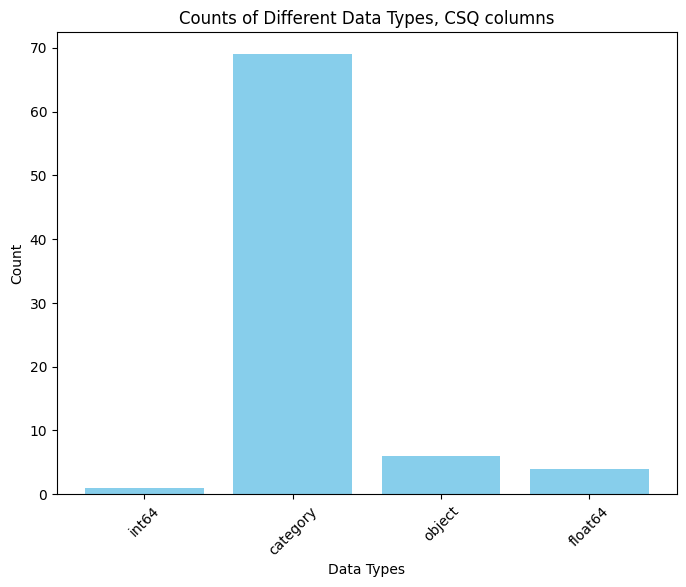

In [ ]:
dtype_counts={}
for val in df_csq.dtypes:
    try:
        dtype_counts[str(val)]+=1
    except:
        dtype_counts[str(val)]=1

data_types = list(dtype_counts.keys())
counts = list(dtype_counts.values())

plt.figure(figsize=(8, 6))
plt.bar(data_types, counts, color='skyblue')
plt.xlabel('Data Types')
plt.ylabel('Count')
plt.title('Counts of Different Data Types, CSQ columns')
plt.xticks(rotation=45)
plt.show()

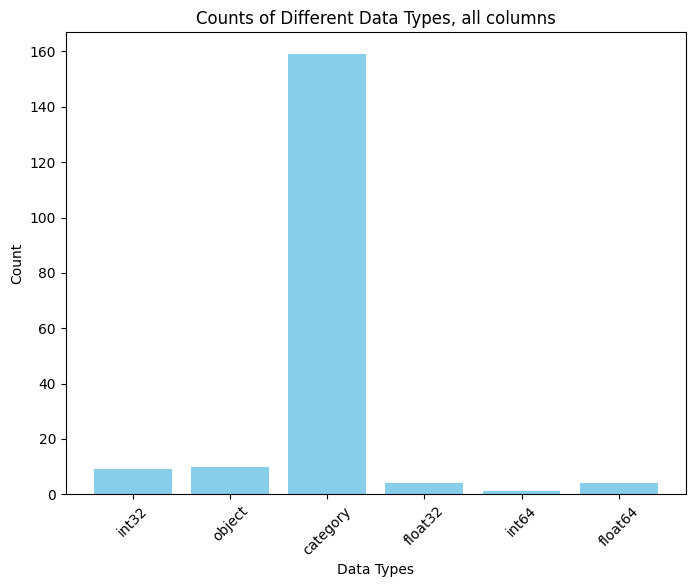

In [ ]:
dtype_counts={}
for val in df.dtypes:
    try:
        dtype_counts[str(val)]+=1
    except:
        dtype_counts[str(val)]=1

data_types = list(dtype_counts.keys())
counts = list(dtype_counts.values())

plt.figure(figsize=(8, 6))
plt.bar(data_types, counts, color='skyblue')
plt.xlabel('Data Types')
plt.ylabel('Count')
plt.title('Counts of Different Data Types, all columns')
plt.xticks(rotation=45)
plt.show()

Heatmap of correlations for all remaining numerical values.

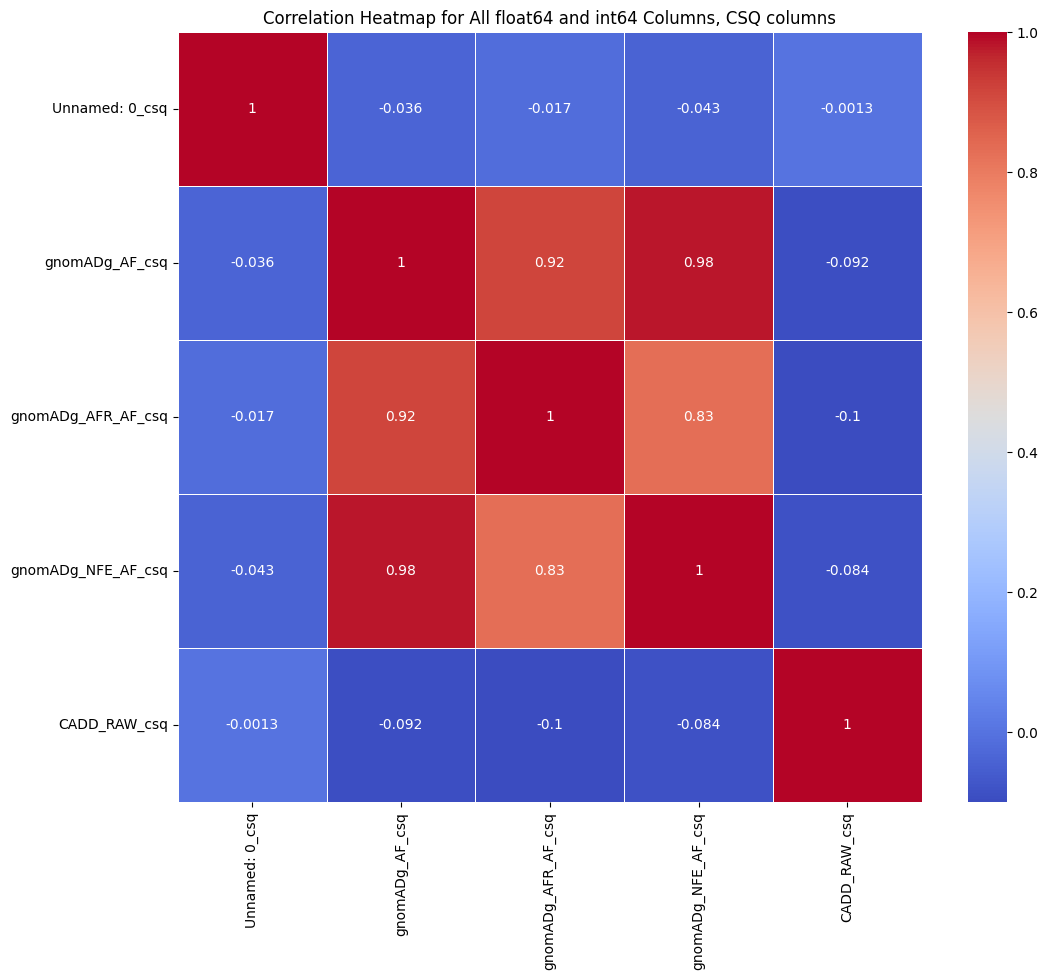

In [ ]:
numeric_df = df_csq.select_dtypes(include=['float64', 'int64', 'int32', 'float32'])


correlation_matrix = numeric_df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Heatmap for All float64 and int64 Columns, CSQ columns')
plt.show()


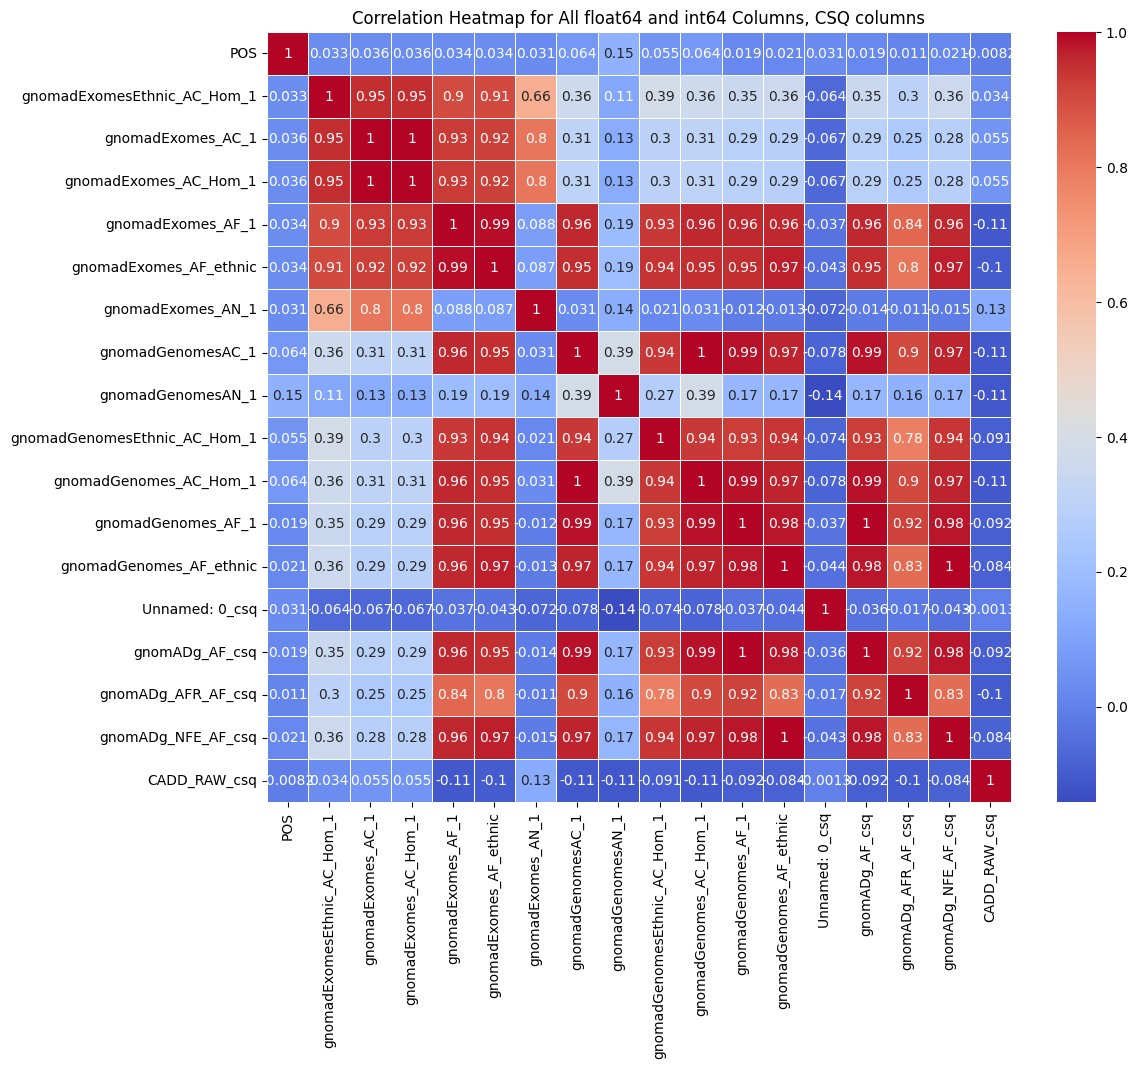

In [ ]:
numeric_df = df.select_dtypes(include=['float64', 'int64', 'int32', 'float32'])


correlation_matrix = numeric_df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Heatmap for All float64 and int64 Columns, CSQ columns')
plt.show()


In [ ]:
acmg_class_names = list(df["ACMG_class"])

In [ ]:
category_columns_df = df.select_dtypes(include=['category'])
for column in category_columns_df:
    category_to_numeric_mapping = {category: index for index, category in enumerate(df[column].cat.categories)}
    df[column] = df[column].cat.codes

object_columns = df.select_dtypes(include=['object'])
for column in object_columns:
    df[column] = df[column].astype('category').cat.codes


category_columns_csq = df_csq.select_dtypes(include=['category'])
for column in category_columns_csq:
    category_to_numeric_mapping = {category: index for index, category in enumerate(df_csq[column].cat.categories)}
    df_csq[column] = df_csq[column].cat.codes

object_columns = df_csq.select_dtypes(include=['object'])
for column in object_columns:
    df_csq[column] = df_csq[column].astype('category').cat.codes

In [ ]:
acmg_class_vals = list(df["ACMG_class"])

In [ ]:
acmg_mapping={}
for i in range(len(acmg_class_names)):
    name = acmg_class_names[i]
    if name not in list(acmg_mapping.keys()):
        acmg_mapping[name] = acmg_class_vals[i]
    if len(list(acmg_mapping.keys())) == 5:
        break
acmg_mapping

{'Uncertain%40Significance': 4,
 'Benign': 0,
 'Likely%40Benign': 1,
 'Likely%40Pathogenic': 2,
 'Pathogenic': 3}

Below are the values of correlation and mutual information Here we see the actual importance of the CSQ as most of its attributes are stronger correlated with the target than as it is a case for the regular data attributes.

Showing correlation between 15 most correlated attributes with our target attribute.

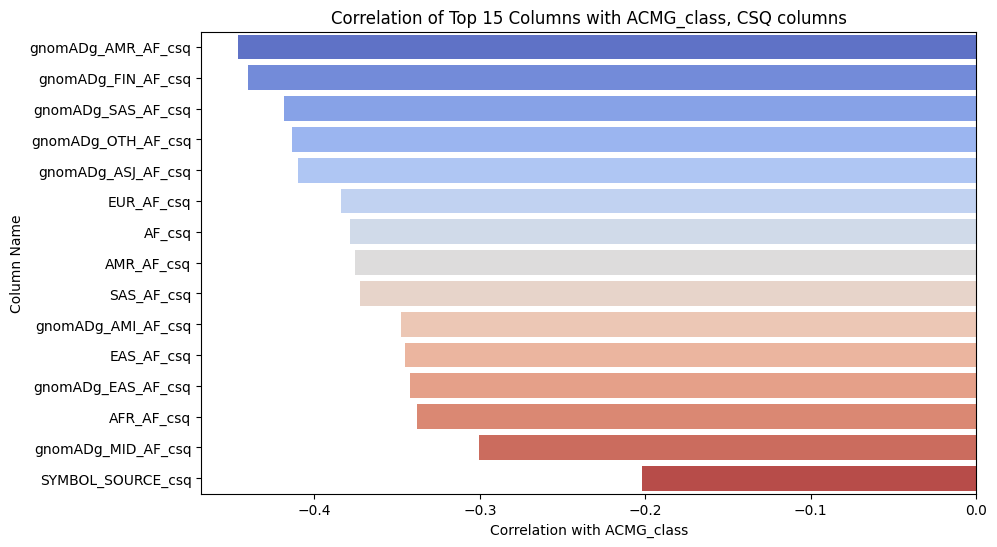

In [ ]:
correlation_with_ACMG_class = df_csq.corr()['ACMG_class'].drop('ACMG_class')

top_columns = correlation_with_ACMG_class.abs().nlargest(15).index

plt.figure(figsize=(10, 6))
sns.barplot(x=correlation_with_ACMG_class[top_columns], y=top_columns, orient='h', palette='coolwarm')
plt.xlabel('Correlation with ACMG_class')
plt.ylabel('Column Name')
plt.title('Correlation of Top 15 Columns with ACMG_class, CSQ columns')
plt.show()

-0.3174541134672194


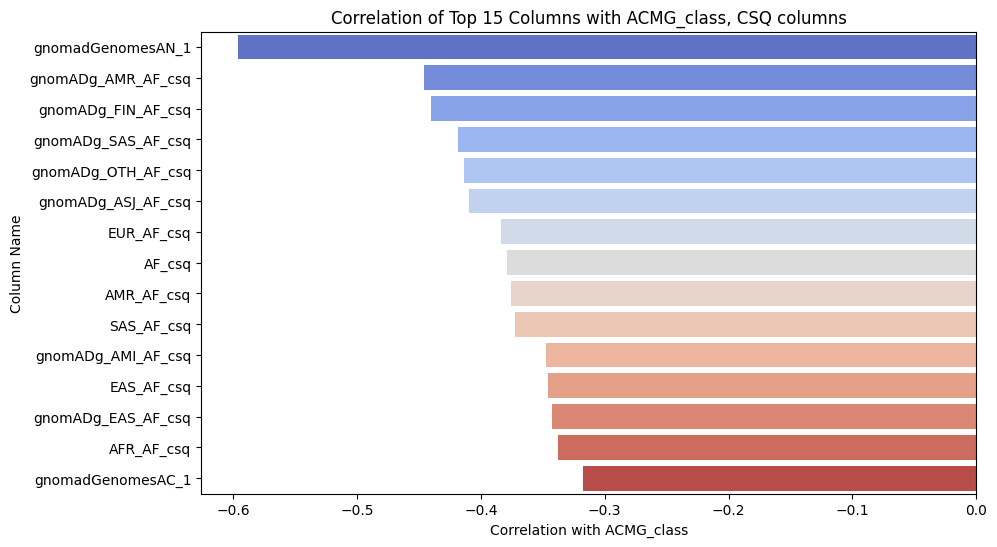

In [ ]:
correlation_with_ACMG_class = df.corr()['ACMG_class'].drop('ACMG_class')

top_columns = correlation_with_ACMG_class.abs().nlargest(15).index
print(correlation_with_ACMG_class['gnomadGenomesAC_1'])

plt.figure(figsize=(10, 6))
sns.barplot(x=correlation_with_ACMG_class[top_columns], y=top_columns, orient='h', palette='coolwarm')
plt.xlabel('Correlation with ACMG_class')
plt.ylabel('Column Name')
plt.title('Correlation of Top 15 Columns with ACMG_class, all columns')
plt.show()

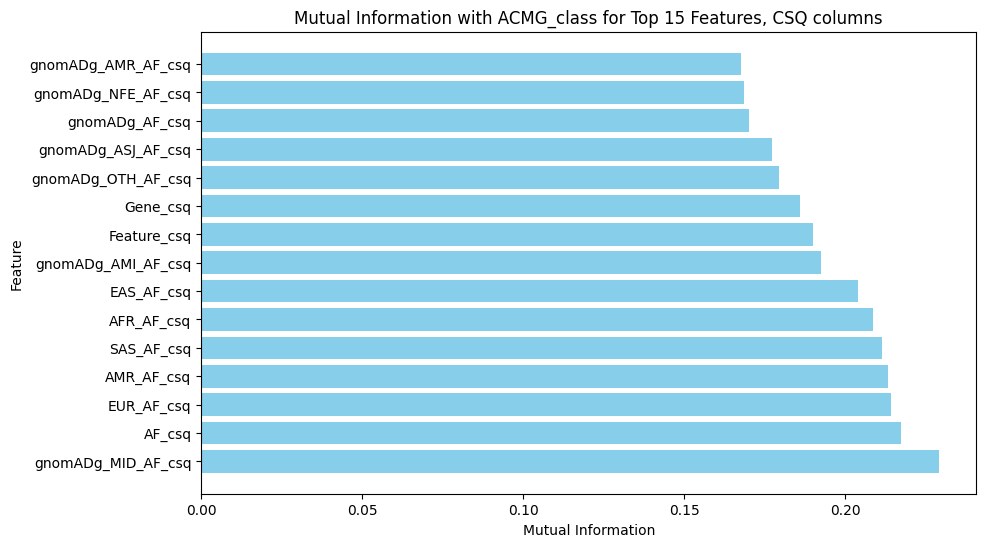

In [ ]:
target_column = 'ACMG_class'
df_copy = df_csq.copy()
non_numeric_columns = df_copy.select_dtypes(exclude=['number']).columns
label_encoders = {}

for column in non_numeric_columns:
    label_encoders[column] = LabelEncoder()
    df_copy[column] = label_encoders[column].fit_transform(df_copy[column])

imputer = SimpleImputer(strategy='mean')
X = df_copy.drop(columns=[target_column])
X_imputed = imputer.fit_transform(X)
y = df_copy[target_column]
mutual_info = mutual_info_classif(X_imputed, y)


mutual_info_df = pd.DataFrame({'Feature': X.columns, 'Mutual Information': mutual_info})
mutual_info_df = mutual_info_df.sort_values(by='Mutual Information', ascending=False)
top_features = mutual_info_df.head(15)

plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Mutual Information'], color='skyblue')
plt.xlabel('Mutual Information')
plt.ylabel('Feature')
plt.title('Mutual Information with ACMG_class for Top 15 Features, CSQ columns')
plt.show()

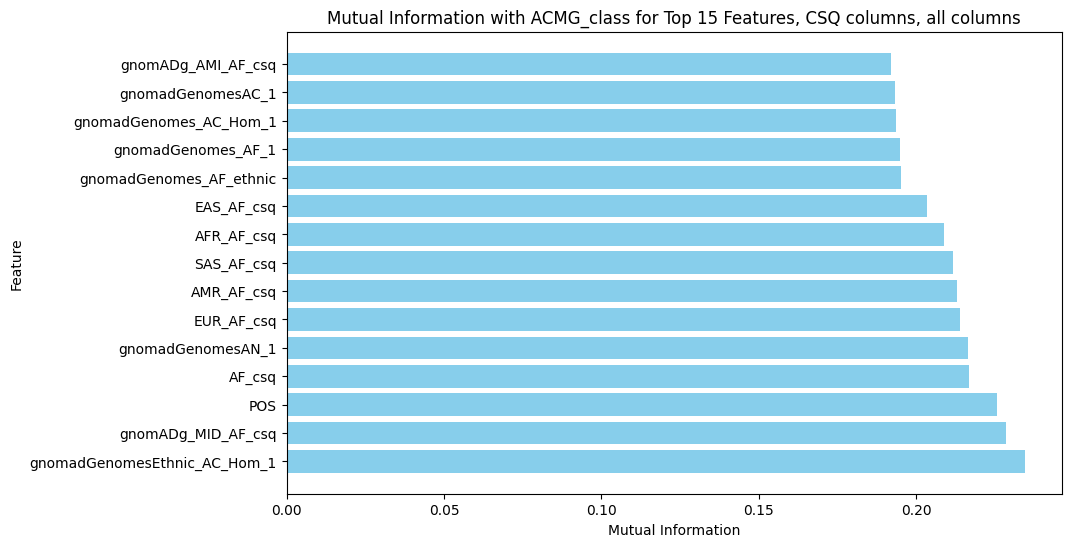

In [ ]:
target_column = 'ACMG_class'
df_copy = df.copy()
non_numeric_columns = df_copy.select_dtypes(exclude=['number']).columns
label_encoders = {}

for column in non_numeric_columns:
    label_encoders[column] = LabelEncoder()
    df_copy[column] = label_encoders[column].fit_transform(df_copy[column])

imputer = SimpleImputer(strategy='mean')
X = df_copy.drop(columns=[target_column])
X_imputed = imputer.fit_transform(X)
y = df_copy[target_column]
mutual_info = mutual_info_classif(X_imputed, y)


mutual_info_df = pd.DataFrame({'Feature': X.columns, 'Mutual Information': mutual_info})
mutual_info_df = mutual_info_df.sort_values(by='Mutual Information', ascending=False)
top_features = mutual_info_df.head(15)

plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Mutual Information'], color='skyblue')
plt.xlabel('Mutual Information')
plt.ylabel('Feature')
plt.title('Mutual Information with ACMG_class for Top 15 Features, CSQ columns, all columns')
plt.show()

## Classification

For the classification new claccifiers: LGBM catboost and XGBM were used.

[('Random Forest', RandomForestClassifier(class_weight={0: 0.23111471650429397,
                                     1: 3.4514560844917295,
                                     2: 716.8451612903226, 3: 1777.776,
                                     4: 2.621547173150087},
                       random_state=42), 'all'), ('Random Forest', RandomForestClassifier(class_weight={0: 0.23111471650429397,
                                     1: 3.4514560844917295,
                                     2: 716.8451612903226, 3: 1777.776,
                                     4: 2.621547173150087},
                       random_state=42), 'csq'), ('AdaBoost', AdaBoostClassifier(random_state=123), 'all'), ('AdaBoost', AdaBoostClassifier(random_state=123), 'csq')]
Classification report for Random Forest:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     77156
           1       0.83      0.80      0.82      5141
           2       0.83      0.28    

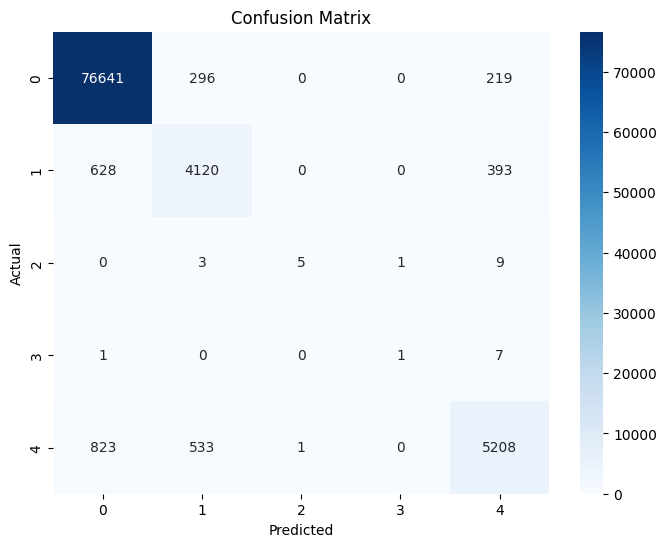

Classification report for Random Forest:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     77156
           1       0.72      0.64      0.68      5141
           2       0.88      0.39      0.54        18
           3       0.25      0.11      0.15         9
           4       0.80      0.76      0.78      6565

    accuracy                           0.95     88889
   macro avg       0.73      0.58      0.63     88889
weighted avg       0.95      0.95      0.95     88889

Confusion matrix for Random Forest, csq columns:


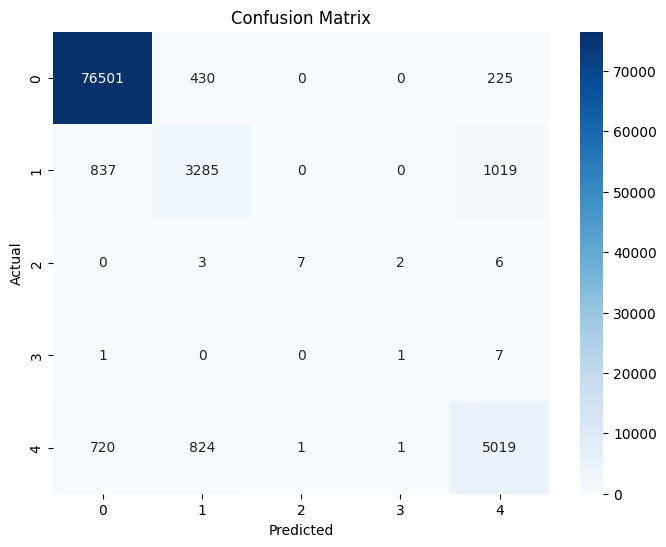

Classification report for AdaBoost:
              precision    recall  f1-score   support

           0       0.98      0.93      0.95     77156
           1       0.29      0.64      0.40      5141
           2       0.04      0.83      0.07        18
           3       0.83      0.56      0.67         9
           4       0.54      0.30      0.39      6565

    accuracy                           0.87     88889
   macro avg       0.53      0.65      0.49     88889
weighted avg       0.90      0.87      0.88     88889

Confusion matrix for AdaBoost, all columns:


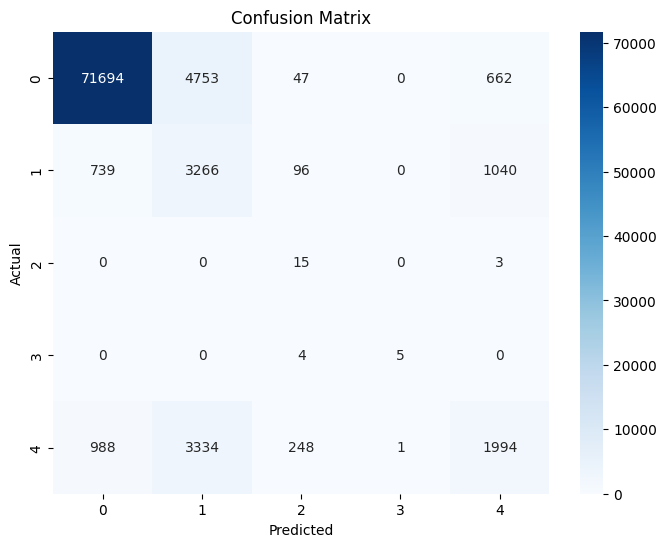

Classification report for AdaBoost:
              precision    recall  f1-score   support

           0       0.99      0.32      0.48     77156
           1       0.07      0.85      0.13      5141
           2       0.03      0.83      0.07        18
           3       0.54      0.78      0.64         9
           4       0.57      0.22      0.31      6565

    accuracy                           0.34     88889
   macro avg       0.44      0.60      0.33     88889
weighted avg       0.90      0.34      0.45     88889

Confusion matrix for AdaBoost, csq columns:


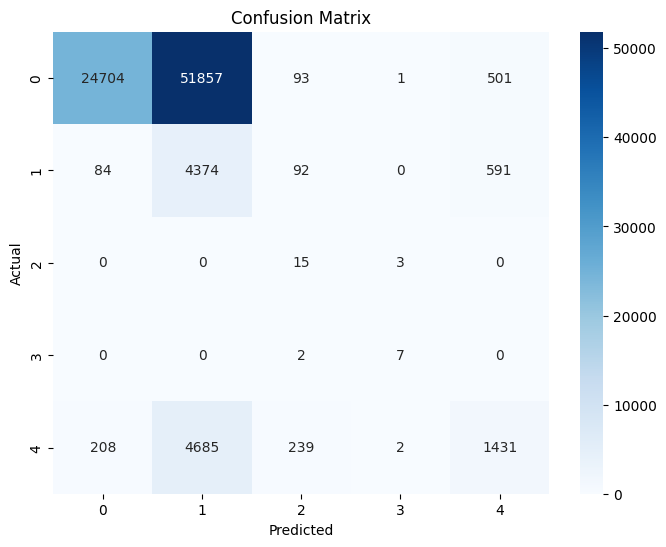

In [ ]:
imputer = SimpleImputer(strategy='median')
X = df.drop(columns=['ACMG_class'])
X = imputer.fit_transform(X)
y = df['ACMG_class']

all_columns_split = train_test_split(X, y, test_size=0.2, random_state=42)

X_csq = df_csq.drop(columns=['ACMG_class'])
X_csq = imputer.fit_transform(X_csq)
y_csq = df_csq['ACMG_class']

csq_columns_split = train_test_split(X_csq, y_csq, test_size=0.2, random_state=42)

class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)

models = [
    ('Random Forest', RandomForestClassifier(class_weight=dict(enumerate(class_weights)), random_state=42)),
    ('AdaBoost', AdaBoostClassifier(random_state=123)),

]

models_and_sets = [(*model, name) for model in models for name in ['all', 'csq']]

for model_name, model, columns in models_and_sets:
    if columns == "all":
        X_train, X_test, y_train, y_test  = all_columns_split
    if columns == "csq":
        X_train, X_test, y_train, y_test  = csq_columns_split

    clf = model

    pipeline = Pipeline([
        ('classifier', clf)
    ])

    if model_name == 'AdaBoost':
        sample_weights = class_weights[np.searchsorted(np.unique(y_train), y_train)]
        pipeline.fit(X_train, y_train, classifier__sample_weight=sample_weights)
    else:
        pipeline.fit(X_train, y_train)

    if model_name != 'AdaBoost':
        y_pred = pipeline.predict(X_test)
        report = classification_report(y_test, y_pred)
        print(f"Classification report for {model_name}:")
        print(report)

        cm = confusion_matrix(y_test, y_pred)
        print(f"Confusion matrix for {model_name}, {columns} columns:")
        plt.figure(figsize=(8, 6))
        class_names = clf.classes_
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()
    else:
        y_pred = pipeline.predict(X_test)

        report = classification_report(y_test, y_pred)
        print(f"Classification report for {model_name}:")
        print(report)

        classes = np.unique(y)
        cm = confusion_matrix(y_test, y_pred, labels=classes)
        print(f"Confusion matrix for {model_name}, {columns} columns:")
        plt.figure(figsize=(8, 6))
        class_names = clf.classes_
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.416802 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23977
[LightGBM] [Info] Number of data points in the train set: 355555, number of used features: 162
[LightGBM] [Info] Start training from score -1.630245
[LightGBM] [Info] Start training from score -1.629008
[LightGBM] [Info] Start training from score -1.563183
[LightGBM] [Info] Start training from score -1.604791
[LightGBM] [Info] Start training from score -1.621538
Classification report for LGBM:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     77156
           1       0.68      0.90      0.77      5141
           2       0.50      0.56      0.53        18
           3       0.80      0.44      0.57         9
           4       0.75      0.87      0.80      6565

    accuracy                           0.95     88889
   macro avg       0.74   

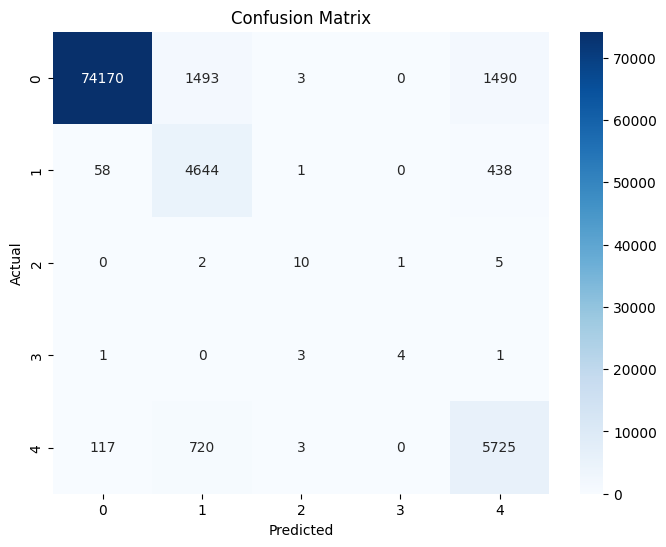

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.220699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15500
[LightGBM] [Info] Number of data points in the train set: 355555, number of used features: 79
[LightGBM] [Info] Start training from score -1.630245
[LightGBM] [Info] Start training from score -1.629008
[LightGBM] [Info] Start training from score -1.563183
[LightGBM] [Info] Start training from score -1.604791
[LightGBM] [Info] Start training from score -1.621538
Classification report for LGBM:
              precision    recall  f1-score   support

           0       0.99      0.93      0.96     77156
           1       0.56      0.82      0.66      5141
           2       0.47      0.50      0.49        18
           3       0.56      0.56      0.56         9
           4       0.61      0.80      0.69      6565

    accuracy                           0.92     88889
   macro avg       0.64    

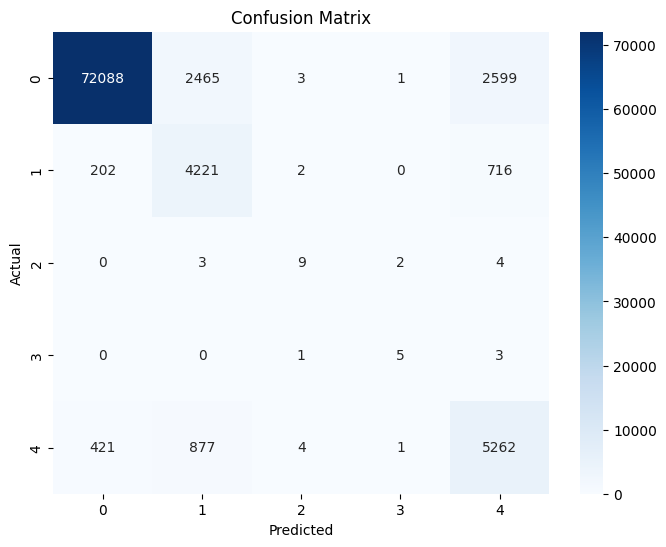

Learning rate set to 0.106763
0:	learn: 1.4135448	total: 572ms	remaining: 9m 31s
1:	learn: 1.3092766	total: 1.21s	remaining: 10m 3s
2:	learn: 1.2155631	total: 1.96s	remaining: 10m 52s
3:	learn: 1.1346665	total: 2.53s	remaining: 10m 29s
4:	learn: 1.0609924	total: 3.18s	remaining: 10m 33s
5:	learn: 1.0001906	total: 3.63s	remaining: 10m 1s
6:	learn: 0.9414737	total: 4.26s	remaining: 10m 4s
7:	learn: 0.8919632	total: 4.78s	remaining: 9m 53s
8:	learn: 0.8426835	total: 5.36s	remaining: 9m 49s
9:	learn: 0.8102284	total: 6.03s	remaining: 9m 57s
10:	learn: 0.7685157	total: 6.81s	remaining: 10m 12s
11:	learn: 0.7356697	total: 7.41s	remaining: 10m 10s
12:	learn: 0.7110362	total: 8.04s	remaining: 10m 10s
13:	learn: 0.6901561	total: 8.66s	remaining: 10m 9s
14:	learn: 0.6652026	total: 9.34s	remaining: 10m 13s
15:	learn: 0.6415558	total: 10.1s	remaining: 10m 20s
16:	learn: 0.6236602	total: 10.6s	remaining: 10m 14s
17:	learn: 0.6083317	total: 11.2s	remaining: 10m 12s
18:	learn: 0.5889226	total: 11.9s	

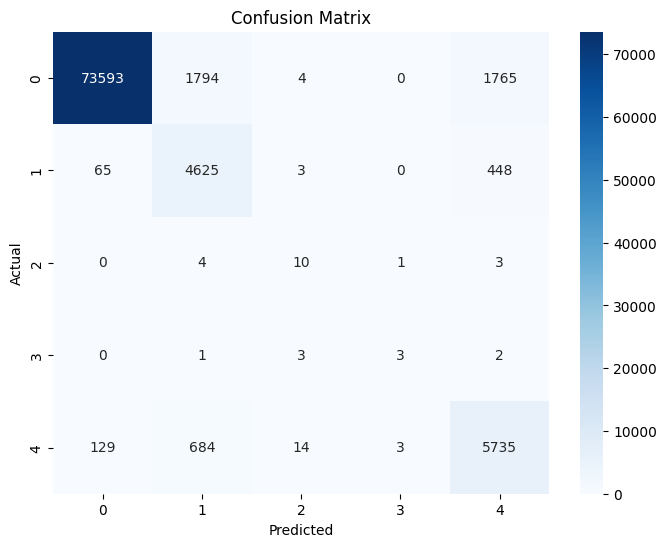

Learning rate set to 0.106763
0:	learn: 1.4466523	total: 550ms	remaining: 9m 9s
1:	learn: 1.3296156	total: 1.08s	remaining: 8m 59s
2:	learn: 1.2403370	total: 1.69s	remaining: 9m 22s
3:	learn: 1.1686989	total: 2.26s	remaining: 9m 21s
4:	learn: 1.1026828	total: 2.82s	remaining: 9m 21s
5:	learn: 1.0466455	total: 3.34s	remaining: 9m 13s
6:	learn: 0.9894305	total: 3.77s	remaining: 8m 54s
7:	learn: 0.9629326	total: 4.38s	remaining: 9m 2s
8:	learn: 0.9210347	total: 4.93s	remaining: 9m 2s
9:	learn: 0.8864112	total: 5.36s	remaining: 8m 50s
10:	learn: 0.8534776	total: 5.77s	remaining: 8m 39s
11:	learn: 0.8298257	total: 6.4s	remaining: 8m 47s
12:	learn: 0.7993644	total: 6.89s	remaining: 8m 42s
13:	learn: 0.7787112	total: 7.47s	remaining: 8m 45s
14:	learn: 0.7592982	total: 7.96s	remaining: 8m 42s
15:	learn: 0.7369556	total: 8.48s	remaining: 8m 41s
16:	learn: 0.7242046	total: 9.05s	remaining: 8m 43s
17:	learn: 0.7019760	total: 9.51s	remaining: 8m 39s
18:	learn: 0.6865173	total: 10s	remaining: 8m 37

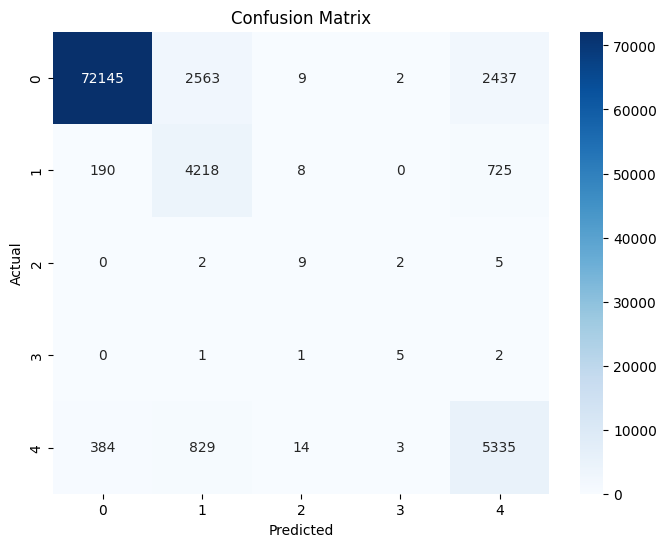

Classification report for XGBoost:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     77156
           1       0.84      0.83      0.83      5141
           2       0.89      0.44      0.59        18
           3       0.80      0.44      0.57         9
           4       0.88      0.84      0.86      6565

    accuracy                           0.97     88889
   macro avg       0.88      0.71      0.77     88889
weighted avg       0.97      0.97      0.97     88889

Confusion matrix for XGBoost, all columns:


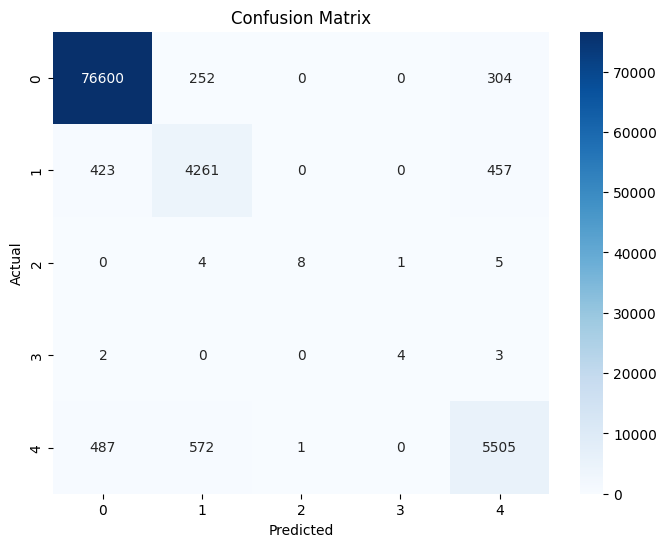

Classification report for XGBoost:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     77156
           1       0.77      0.69      0.73      5141
           2       0.75      0.50      0.60        18
           3       0.80      0.44      0.57         9
           4       0.82      0.75      0.78      6565

    accuracy                           0.95     88889
   macro avg       0.82      0.67      0.73     88889
weighted avg       0.95      0.95      0.95     88889

Confusion matrix for XGBoost, csq columns:


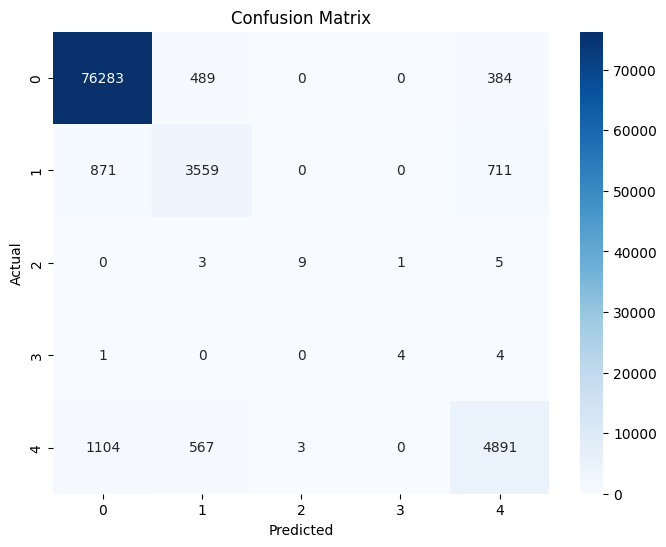

In [ ]:
all_columns_split = train_test_split(X, y, test_size=0.2, random_state=42)

X_csq = df_csq.drop(columns=['ACMG_class'])
X_csq = imputer.fit_transform(X_csq)
y_csq = df_csq['ACMG_class']

csq_columns_split = train_test_split(X_csq, y_csq, test_size=0.2, random_state=42)

class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)

models = [
    ('LGBM', LGBMClassifier()),
    ('Catboost', CatBoostClassifier()),
    ('XGBoost', XGBClassifier())

]

models_and_sets = [(*model, name) for model in models for name in ['all', 'csq']]

for model_name, model, columns in models_and_sets:
    if columns == "all":
        X_train, X_test, y_train, y_test  = all_columns_split
    if columns == "csq":
        X_train, X_test, y_train, y_test  = csq_columns_split

    clf = model

    pipeline = Pipeline([
        ('classifier', clf)
    ])

    if model_name == 'Catboost':
        sample_weights = class_weights[np.searchsorted(np.unique(y_train), y_train)]
        pipeline.fit(X_train, y_train, classifier__sample_weight=sample_weights)
    elif model_name == 'LGBM':
        sample_weights = class_weights[np.searchsorted(np.unique(y_train), y_train)]
        pipeline.fit(X_train, y_train, classifier__sample_weight=sample_weights)
    else:
        pipeline.fit(X_train, y_train)



    y_pred = pipeline.predict(X_test)

    report = classification_report(y_test, y_pred)
    print(f"Classification report for {model_name}:")
    print(report)

    classes = np.unique(y)
    cm = confusion_matrix(y_test, y_pred, labels=classes)
    print(f"Confusion matrix for {model_name}, {columns} columns:")
    plt.figure(figsize=(8, 6))
    class_names = clf.classes_
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()